# Linker Design with DEVELOP

The purpose of this notebook is to demonstrate a simple, automated, end-to-end workflow for using DEVELOP.

In this notebook, we will explore how DEVELOP [[Link]](https://www.biorxiv.org/content/10.1101/2021.04.27.441676v1) can be used to perform linker design. To demonstrate this, we will use the phenol linker example (PDB ID: 2FLR) from our paper (see Table 1).

Please note: we make no claims about the suitability of the generated molecules in this example, or even if the fragments chosen are sensible to link together.

Any questions, comments or feedback, please email deane@stats.ox.ac.uk

### Basic settings

In [1]:
# How many cores for multiprocessing
n_cores = 1

# Google Colab Instructions

If you would like to test DEVELOP without local installation, you can use Google Colab for free!

If you are running this locally, you should not run the cells in this section. They are solely to setup Colab to use DEVELOP.

In [2]:
# Clone repo in Colab
!git clone https://github.com/fimrie/DEVELOP/
# Enter repo
%cd DEVELOP

Cloning into 'DEVELOP'...
remote: Enumerating objects: 2105, done.
remote: Counting objects: 100% (2105/2105), done.
remote: Compressing objects: 100% (1787/1787), done.
remote: Total 2105 (delta 169), reused 2102 (delta 166), pack-reused 0
Receiving objects: 100% (2105/2105), 43.98 MiB | 22.30 MiB/s, done.
Resolving deltas: 100% (169/169), done.
/content/DEVELOP
/content/DEVELOP/examples


In [2]:
# Use Tensorflow 1.x
%tensorflow_version 1.x

import tensorflow as tf 
print(tf.__version__)

UsageError: Line magic function `%tensorflow_version` not found.


In [3]:
# Install packages

# Molgrid
!pip install molgrid

# RDKit
!pip install rdkit-pypi

  ERROR: Could not find a version that satisfies the requirement rdkit-pypi (from versions: none)
ERROR: No matching distribution found for rdkit-pypi


# Imports

In [3]:
# If on Colab (otherwise likely in examples directory already)
%cd examples

import sys
sys.path.append("../")
sys.path.append("../analysis")

[Errno 2] No such file or directory: 'examples'
/home/bailab/data/hqy/PROTACs/DEVELOP/examples


In [4]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolDrawing, DrawingOptions
from rdkit.Chem import MolStandardize

import numpy as np

from itertools import product
from joblib import Parallel, delayed
import re
from collections import defaultdict

from IPython.display import clear_output
IPythonConsole.ipython_useSVG = True

import DEVELOP
from DEVELOP import DenseGGNNChemModel
import frag_utils
import rdkit_conf_parallel
import example_utils

/home/bailab/software/anaconda3/envs/DEVELOP_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bailab/software/anaconda3/envs/DEVELOP_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bailab/software/anaconda3/envs/DEVELOP_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/hom

In [5]:
import data.prepare_data_linker_design
from data.prepare_data_linker_design import read_file, preprocess

# Load starting molecule and design example

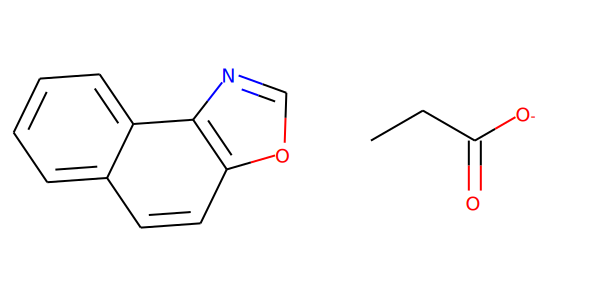

In [7]:
frag_1_path = './cluster_out_1_sorted_brick4.sdf'
frag_2_path = './cluster_out_3_sorted_brick4.sdf'

frag_1_sdf = Chem.SDMolSupplier(frag_1_path)
frag_1_smi = Chem.MolToSmiles(frag_1_sdf[0])

frag_2_sdf = Chem.SDMolSupplier(frag_2_path)
frag_2_smi = Chem.MolToSmiles(frag_2_sdf[0])

img = Draw.MolsToGridImage([Chem.MolFromSmiles(frag_1_smi), Chem.MolFromSmiles(frag_2_smi)], molsPerRow=2, subImgSize=(300, 300))
img

We'll now preprocess these into a format where they can be linked with DEVELOP.

To do so, we'll first need to decide the core we want to replace and add exit vectors to each of the remaining fragments.

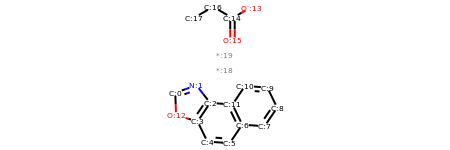

In [8]:
combo_no_exit = Chem.CombineMols(frag_1_sdf[0],frag_2_sdf[0])
combo = Chem.CombineMols(combo_no_exit, Chem.MolFromSmiles("*.*"))
combo_2d = Chem.Mol(combo)
_ = AllChem.Compute2DCoords(combo_2d)
example_utils.mol_with_atom_index(combo_2d)

We need to select which pairs of atoms we want to break to construct the exit vector. Let's do this, and then view the new molecule.

In [9]:
atom_idx_1 = 9
atom_idx_2 = 17

18


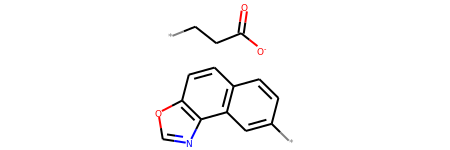

In [10]:
edcombo = Chem.EditableMol(combo)
num_heavy_atoms = combo.GetNumHeavyAtoms()
print(num_heavy_atoms)
edcombo.AddBond(num_heavy_atoms, atom_idx_1, order=Chem.rdchem.BondType.SINGLE)
edcombo.AddBond(num_heavy_atoms+1, atom_idx_2, order=Chem.rdchem.BondType.SINGLE)
editedcombo = edcombo.GetMol()
_ = AllChem.Compute2DCoords(editedcombo)
Chem.SanitizeMol(editedcombo)
editedcombo

In [11]:
mol_to_link = edcombo.GetMol()
Chem.SanitizeMol(mol_to_link)

# Convert exit vectors to carbons for conformer generation
du = Chem.MolFromSmiles('*')
mol_to_link_carbon = AllChem.ReplaceSubstructs(mol_to_link,du,Chem.MolFromSmiles('C'),True)[0]
Chem.SanitizeMol(mol_to_link_carbon)
# Generate conformer
mol_to_link_carbon = Chem.AddHs(mol_to_link_carbon)
AllChem.ConstrainedEmbed(mol_to_link_carbon, combo_no_exit, randomseed=42)
mol_to_link_carbon = Chem.RemoveHs(mol_to_link_carbon)

RDKit WARNING: [09:24:18] Constrained conformer generation (via the coordMap argument) does not work with molecules that have multiple fragments.
[09:24:18] Constrained conformer generation (via the coordMap argument) does not work with molecules that have multiple fragments.


In [12]:
# Add this conformer to the two unlinked fragments
conf = mol_to_link.GetConformer()
ref_conf = mol_to_link_carbon.GetConformer()
for i in range(mol_to_link_carbon.GetNumAtoms()):
    pos = list(ref_conf.GetAtomPosition(i))
    conf.SetAtomPosition(i, pos)
conf.SetId(0)
_ = mol_to_link.AddConformer(conf)

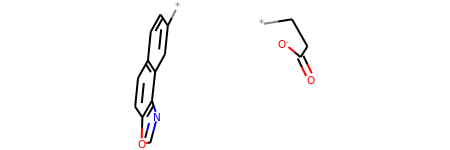

In [13]:
mol_to_link

# Prepare example as input data

We now need to calculate the structural information, prepare the pharmacophoric information, and preprocess this example into the form required by DEVELOP.

In [14]:
# Get distance and angle between fragments
dist, ang = frag_utils.compute_distance_and_angle(mol_to_link, "", Chem.MolToSmiles(mol_to_link))
print(Chem.MolToSmiles(mol_to_link), dist, ang)

*CCC(=O)[O-].*c1ccc2ccc3ocnc3c2c1 6.148099125269704 2.156161674298479


In [15]:
# Write data to file
data_path = "./frag1_frag2_out_new.txt"
print(Chem.MolToSmiles(mol_to_link))
with open(data_path, 'w') as f:
    f.write("%s %s %s" % (Chem.MolToSmiles(mol_to_link), dist, ang))

*CCC(=O)[O-].*c1ccc2ccc3ocnc3c2c1


In [82]:
raw_data = read_file(data_path, add_idx=True, calc_pharm_counts=True)
preprocess(raw_data, "zinc", "linker_design_test", "./", False)

Finished reading: 1 / 1
Parsing smiles as graphs.
Processed: 1 / 1
Saving data
Length raw data: 	1
Length processed data: 	1


In [88]:
# Calculate Pharmacophoric information
fragments_path = 'linker_design_fragments.sdf'
pharmacophores_path = 'linker_design_pharmacophores.sdf'
fragmentations_pharm, fails = frag_utils.create_frags_pharma_sdf_dataset([['*CCC(=O)[O-].*O/N=C(\c1ccccc1)C(C)C', '', '*CCC(=O)[O-].*O/N=C(\c1ccccc1)C(C)C', dist, ang]], 
                                                                         '1_brick1_3_brick4.sdf', dataset="CASF",
                                                                         sdffile=fragments_path,
                                                                         sdffile_pharm=pharmacophores_path,
                                                                         prot="", verbose=True)

*CCC(=O)[O-].*O/N=C(\c1ccccc1)C(C)C  *CCC(=O)[O-].*O/N=C(\c1ccccc1)C(C)C
*CCC(=O)[O-].*O/N=C(\c1ccccc1)C(C)C *CCC(=O)[O-].*O/N=C(\c1ccccc1)C(C)C 
 *CCC(=O)[O-].*O/N=C(\c1ccccc1)C(C)C
Done: , Mol: 0, Successes: 0


In [48]:
# Write .types file
with open("linker_design_example.types", 'w') as f:
  f.write('1 ' + pharmacophores_path + ' ' + fragments_path)

# Load DEVELOP model and generate new molecules

Let's now setup and generate molecules with DEVELOP. The below settings will generate 100 molecules for each length of linker from nine to ten atoms, inclusively.

In [98]:
# Arguments for DEVELOP
args = defaultdict(None)
args['--dataset'] = 'zinc'
args['--config'] = '{"generation": true, \
                     "batch_size": 1, \
                     "number_of_generation_per_valid": 250, \
                     "train_file": "./molecules_1_brick4_3_brick4_out.json", \
                     "valid_file": "./molecules_1_brick4_3_brick4_out.json", \
                     "train_struct_file": "./1_brick4_3_brick4.types", \
                     "valid_struct_file": "./1_brick4_3_brick4.types", \
                     "struct_data_root": "./", \
                     "output_name": "1_brick4_3_brick4_generation.smi"}'
args['--freeze-graph-model'] = False
args['--restore'] = '../models/linker_design/pretrained_DEVELOP_model.pickle'

In [99]:
# Setup model and generate molecules
model = DenseGGNNChemModel(args)
model.train()
# Free up some memory
model = ''

Run 2022-04-03-16-31-58_30350 starting with following parameters:
{"task_sample_ratios": {}, "use_edge_bias": true, "clamp_gradient_norm": 1.0, "out_layer_dropout_keep_prob": 1.0, "tie_fwd_bkwd": true, "random_seed": 0, "batch_size": 1, "prior_learning_rate": 0.05, "stop_criterion": 0.01, "num_epochs": 10, "epoch_to_generate": 10, "number_of_generation_per_valid": 250, "maximum_distance": 50, "use_argmax_generation": false, "residual_connection_on": true, "residual_connections": {"2": [0], "4": [0, 2], "6": [0, 2, 4], "8": [0, 2, 4, 6], "10": [0, 2, 4, 6, 8], "12": [0, 2, 4, 6, 8, 10], "14": [0, 2, 4, 6, 8, 10, 12]}, "num_timesteps": 7, "hidden_size": 32, "encoding_size": 4, "kl_trade_off_lambda": 0.3, "learning_rate": 0.001, "graph_state_dropout_keep_prob": 1, "compensate_num": 0, "train_file": "./molecules_1_brick4_3_brick4_out.json", "valid_file": "./molecules_1_brick4_3_brick4_out.json", "train_struct_file": "./1_brick4_3_brick4.types", "valid_struct_file": "./1_brick4_3_brick4.typ

2022-04-03 16:32:01.187359: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
2022-04-03 16:32:01.482242: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz
2022-04-03 16:32:01.502401: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55a756744040 executing computations on platform Host. Devices:
2022-04-03 16:32:01.502585: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2022-04-03 16:32:02.123751: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcuda.so.1
2022-04-03 16:32:02.329966: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55a759d46950 executing computations on platform CUDA. Devices:
2022-04-03 16:32:02.330043: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device 

2022-04-03 16:32:09.554020: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1181] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-04-03 16:32:09.554081: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1187]      0 
2022-04-03 16:32:09.554098: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1200] 0:   N 
2022-04-03 16:32:09.566413: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1326] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 6988 MB memory) -> physical GPU (device: 0, name: Quadro P4000, pci bus id: 0000:2d:00.0, compute capability: 6.1)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.



KeyError: 'use_graph'

# Assess generated molecules

Let's calculate some 2D and 3D properties of the generated molecules. We follow the same procedure to filter/score the molecules as described in our paper describing DEVELOP.

In [6]:
# Load molecules
generated_smiles = frag_utils.read_triples_file("./1_brick1_3_brick4_generated_smiles.smi")

in_mols = [smi[1] for smi in generated_smiles]
frag_mols = [smi[0] for smi in generated_smiles]
gen_mols = [smi[2] for smi in generated_smiles]

du = Chem.MolFromSmiles('*')
clean_frags = [Chem.MolToSmiles(Chem.RemoveHs(AllChem.ReplaceSubstructs(Chem.MolFromSmiles(smi),du,Chem.MolFromSmiles('[H]'),True)[0])) for smi in frag_mols]

clear_output(wait=True)
print("Done")

ING: not removing hydrogen atom without neighbors
[09:47:38] WARNING: not removing hydrogen atom without neighbors
[09:47:38] WARNING: not removing hydrogen atom without neighbors
[09:47:38] WARNING: not removing hydrogen atom without neighbors
[09:47:38] WARNING: not removing hydrogen atom without neighbors
[09:47:38] WARNING: not removing hydrogen atom without neighbors
[09:47:38] WARNING: not removing hydrogen atom without neighbors
[09:47:38] WARNING: not removing hydrogen atom without neighbors
[09:47:38] WARNING: not removing hydrogen atom without neighbors
[09:47:38] WARNING: not removing hydrogen atom without neighbors
[09:47:38] WARNING: not removing hydrogen atom without neighbors
[09:47:38] WARNING: not removing hydrogen atom without neighbors
[09:47:38] WARNING: not removing hydrogen atom without neighbors
[09:47:38] WARNING: not removing hydrogen atom without neighbors
[09:47:38] WARNING: not removing hydrogen atom without neighbors
[09:47:38] WARNING: not removing hydroge

Done


emoving hydrogen atom without neighbors
[09:47:39] WARNING: not removing hydrogen atom without neighbors
[09:47:39] WARNING: not removing hydrogen atom without neighbors
[09:47:39] WARNING: not removing hydrogen atom without neighbors
[09:47:39] WARNING: not removing hydrogen atom without neighbors
[09:47:39] WARNING: not removing hydrogen atom without neighbors
[09:47:39] WARNING: not removing hydrogen atom without neighbors
[09:47:39] WARNING: not removing hydrogen atom without neighbors
[09:47:39] WARNING: not removing hydrogen atom without neighbors
[09:47:39] WARNING: not removing hydrogen atom without neighbors
[09:47:39] WARNING: not removing hydrogen atom without neighbors
[09:47:39] WARNING: not removing hydrogen atom without neighbors
[09:47:39] WARNING: not removing hydrogen atom without neighbors
[09:47:39] WARNING: not removing hydrogen atom without neighbors
[09:47:39] WARNING: not removing hydrogen atom without neighbors
[09:47:39] WARNING: not removing hydrogen atom wit

## 2D analysis


In [7]:
# Check valid
results = []
for in_mol, frag_mol, gen_mol, clean_frag in zip(in_mols, frag_mols, gen_mols, clean_frags):
    if len(Chem.MolFromSmiles(gen_mol).GetSubstructMatch(Chem.MolFromSmiles(clean_frag)))>0:
        results.append([in_mol, frag_mol, gen_mol, clean_frag])

print("Number of generated SMILES: \t%d" % len(generated_smiles))
print("Number of valid SMILES: \t%d" % len(results))
print("%% Valid: \t\t\t%.2f%%" % (len(results)/len(generated_smiles)*100))

Number of generated SMILES: 	550
Number of valid SMILES: 	393
% Valid: 			71.45%


In [8]:
# Determine linkers of generated molecules
linkers = Parallel(n_jobs=n_cores)(delayed(frag_utils.get_linker)(Chem.MolFromSmiles(m[2]), Chem.MolFromSmiles(m[3]), m[1]) \
                                   for m in results)
# Standardise linkers
for i, linker in enumerate(linkers):
    if linker == "":
        continue
    try:
      linker = Chem.MolFromSmiles(re.sub('[0-9]+\*', '*', linker))
      Chem.rdmolops.RemoveStereochemistry(linker)
      linkers[i] = MolStandardize.canonicalize_tautomer_smiles(Chem.MolToSmiles(linker))
    except:
      print(linker)
# Update results
for i in range(len(results)):
    results[i].append(linkers[i])
    
clear_output(wait=True)
print("Done")

Done


In [9]:
# Create dictionary of results
results_dict = {}
for res in results:
    if res[0]+'.'+res[1] in results_dict: # Unique identifier - starting fragments and original molecule
        results_dict[res[0]+'.'+res[1]].append(tuple(res))
    else:
        results_dict[res[0]+'.'+res[1]] = [tuple(res)]

In [10]:
# Check uniqueness
print("Unique molecules: %.2f%%" % (frag_utils.unique(results_dict.values())*100))

Unique molecules: 91.60%


In [11]:
# Check if molecules pass 2D filters 
filters_2d = frag_utils.calc_filters_2d_dataset(results, pains_smarts_loc="../analysis/wehi_pains.csv", n_cores=n_cores)

results_filt = []
for res, filt in zip(results, filters_2d):
    if filt[0] and filt[1] and filt[2]:
        results_filt.append(res)
        
clear_output(wait=True)        
print("Pass all 2D filters: \t\t\t\t%.2f%%" % (len(results_filt)/len(results)*100))
print("Valid and pass all 2D filters: \t\t\t%.2f%%" % (len(results_filt)/len(generated_smiles)*100))
print("Pass synthetic accessibility (SA) filter: \t%.2f%%" % (len([f for f in filters_2d if f[0]])/len(filters_2d)*100))
print("Pass ring aromaticity filter: \t\t\t%.2f%%" % (len([f for f in filters_2d if f[1]])/len(filters_2d)*100))
print("Pass SA and ring filters: \t\t\t%.2f%%" % (len([f for f in filters_2d if f[0] and f[1]])/len(filters_2d)*100))
print("Pass PAINS filters: \t\t\t\t%.2f%%" % (len([f for f in filters_2d if f[2]])/len(filters_2d)*100))

Pass all 2D filters: 				54.96%
Valid and pass all 2D filters: 			39.27%
Pass synthetic accessibility (SA) filter: 	57.76%
Pass ring aromaticity filter: 			93.13%
Pass SA and ring filters: 			55.73%
Pass PAINS filters: 				98.98%


In [12]:
# Get unique molecules
print("Number molecules passing 2D filters:\t\t%d" % len(results_filt))
results_filt_unique = example_utils.unique_mols(results_filt)
print("Number unique molecules passing 2D filters:\t%d" % len(results_filt_unique))

Number molecules passing 2D filters:		216
Number unique molecules passing 2D filters:	183


## View most similar molecules

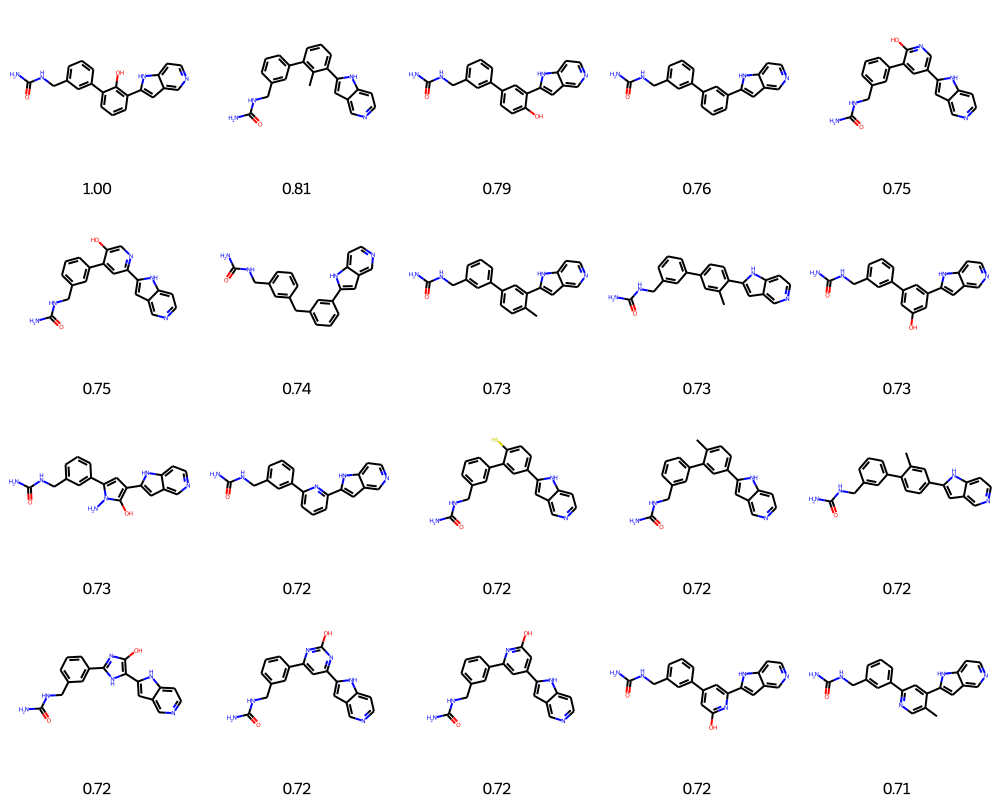

In [104]:
from rdkit.Chem import DataStructs

# Calculate Tanimoto similarity of Morgan fingerprints (radius 2, 2048 bits)
smis = [res[2] for res in results_filt_unique]
gen_fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smi),2, 2048) for smi in smis]
orig_fp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(in_mols[0]),2, 2048)

gen_sims = [DataStructs.TanimotoSimilarity(orig_fp, gen_fp) for gen_fp in gen_fps]

best_mols = sorted(list(zip(smis, gen_sims)), key=lambda x: x[1], reverse=True)[:20]

mols = [Chem.MolFromSmiles(m[0]) for m in best_mols]

img = Draw.MolsToGridImage(mols,
                     molsPerRow=5, legends=["%.2f" % m[1] for m in best_mols],
                    )
img